# Task 3: Analyze product semantics
Our database contains information about numerical product ratings with text comments. I have heard that modern algorithms can read and understand these reviews. Let's implement the functionality to classify positive/negative comments and summarize the analytics. I'm interested in the correlation of text comments with a numerical rating (1-5), products with the best/worst reviews, and sellers who collect only negative feedback.
I'd also like to highlight such an entity as price in the comment text so that the analytics department can review this information for competitors' prices.

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier

import nltk
import re
import string
from nltk import tokenize
from nltk.tokenize import word_tokenize

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from prepare import *

In [2]:
data_dir = 'S_Data/'
dicts_dir = 'S_Data/dicts/'

data = get_data(data_dir)
dicts = get_data(dicts_dir, sep=';')

In [3]:
df_reviews = data['order_reviews']
df_orders = data['orders']
df_order_items = data['order_items']
df_products = data['products']

# Data overview
Let's look at the main features in recall-related data. Consider how we should present the final dataset:

In [4]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


We'll only need the columns review_score, review_comment_title, review_comment_message and also review_id as an index of dataframe.

In [5]:
df = df_reviews[['review_id', 'review_score', 'review_comment_title', 'review_comment_message']].set_index('review_id')
df.head()

,review_score,review_comment_title,review_comment_message
review_id,,,
7bc2406110b926393aa56f80a40eba40,4,NaN,NaN
80e641a11e56f04c1ad469d5645fdfde,5,NaN,NaN
228ce5500dc1d8e020d8d1322874b6f0,5,NaN,NaN
e64fb393e7b32834bb789ff8bb30750e,5,NaN,Recebi bem antes do prazo estipulado.
f7c4243c7fe1938f181bec41a392bdeb,5,NaN,Parabéns lojas lannister adorei comprar pela I...


Let's look at the number of null values in each of the columns:

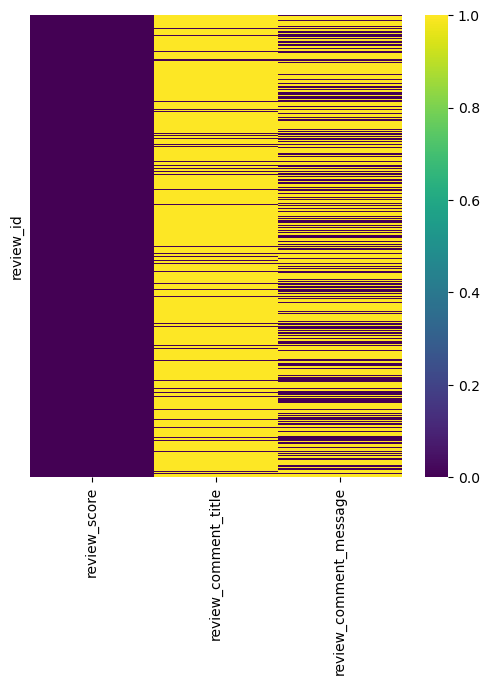

In [6]:
plt.figure(figsize=(6, 6))
sns.heatmap(df.isnull(), cmap='viridis')
plt.yticks([]);

As we can see, a lot of people did not leave comments when evaluating products. When processing the data, it will be necessary to merge review_title and review_message and discard NaN values.

# Data preparation

In [77]:
df.fillna('', inplace=True)
df['text'] = df['review_comment_title'] + " " + df['review_comment_message']

In [78]:
def score_to_categorical(score):
    if score < 5/3:
        return 'negative'
    elif score > 10/3:
        return 'positive'
    else:
        return 'neutral'

In [79]:
df['score_cat'] = df['review_score'].apply(score_to_categorical)
df.head()

,review_score,review_comment_title,review_comment_message,text,score_cat
review_id,,,,,
7bc2406110b926393aa56f80a40eba40,4,,,,positive
80e641a11e56f04c1ad469d5645fdfde,5,,,,positive
228ce5500dc1d8e020d8d1322874b6f0,5,,,,positive
e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,positive
f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,positive


In [80]:
df_filtered = df[df['text'] != ' '][['text', 'score_cat']]
df_filtered.head()

,text,score_cat
review_id,,
e64fb393e7b32834bb789ff8bb30750e,Recebi bem antes do prazo estipulado.,positive
f7c4243c7fe1938f181bec41a392bdeb,Parabéns lojas lannister adorei comprar pela ...,positive
8670d52e15e00043ae7de4c01cc2fe06,recomendo aparelho eficiente. no site a marca ...,positive
4b49719c8a200003f700d3d986ea1a19,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",positive
3948b09f7c818e2d86c9a546758b2335,"Super recomendo Vendedor confiável, produto ok...",positive


In [81]:
df_filtered['score_cat'].value_counts()

positive    28218
negative     9263
neutral      6001
Name: score_cat, dtype: int64

Now we will remove punctuation from the text:

In [84]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Данил\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [85]:
def remove_punctuation_and_special_chars(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub(r'[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s]', '', text)
    return text

In [86]:
X = []
for text in X_res:
    X.append(remove_punctuation_and_special_chars(text))

Let's test if everything is ok:

In [88]:
i = 4
print("Original text: ", X_res[i][0])
print("\nWithout punctuation: ", X[i])

Original text:   Recebi o prod que pedi. Não serviu pq pedi pelas medidas erradas fornecidas no site.Pedi troca por numero menor. Não me deram atenção. Pedi cancelamento. Se não for possivel fico com o prejuizo.

Without punctuation:   Recebi o prod que pedi Não serviu pq pedi pelas medidas erradas fornecidas no sitePedi troca por numero menor Não me deram atenção Pedi cancelamento Se não for possivel fico com o prejuizo


We also need to lower all the words. If we get a new message, we need to prepare it before using our model on it. So let's create a function that would do all needed for text preparing:

In [121]:
def prepare_text(text):
    text = str(text).lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    #result = word_tokenize(text)
    return text

In [91]:
prepare_text('Recebi o prod que pedi. Não serviu pq pedi pelas medidas erradas fornecidas no site.Pedi troca por numero menor. Não me deram atenção. Pedi cancelamento. Se não for possivel fico com o prejuizo.')

['recebi',
 'o',
 'prod',
 'que',
 'pedi',
 'no',
 'serviu',
 'pq',
 'pedi',
 'pelas',
 'medidas',
 'erradas',
 'fornecidas',
 'no',
 'sitepedi',
 'troca',
 'por',
 'numero',
 'menor',
 'no',
 'me',
 'deram',
 'ateno',
 'pedi',
 'cancelamento',
 'se',
 'no',
 'for',
 'possivel',
 'fico',
 'com',
 'o',
 'prejuizo']

After creating a preparing function we will form out dataset with the full strings and next we will preprocess it with our function and do a pipeline with vectorization and model:

In [179]:
#dataset = pd.DataFrame({'text': np.squeeze(X_res), 'target': y_res})
dataset = pd.DataFrame({'text': df_filtered['text'], 'target': df_filtered['score_cat']})
dataset.head()

,text,target
review_id,,
e64fb393e7b32834bb789ff8bb30750e,Recebi bem antes do prazo estipulado.,positive
f7c4243c7fe1938f181bec41a392bdeb,Parabéns lojas lannister adorei comprar pela ...,positive
8670d52e15e00043ae7de4c01cc2fe06,recomendo aparelho eficiente. no site a marca ...,positive
4b49719c8a200003f700d3d986ea1a19,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",positive
3948b09f7c818e2d86c9a546758b2335,"Super recomendo Vendedor confiável, produto ok...",positive


In [180]:
X = [prepare_text(text) for text in list(dataset['text'])]

#y = pd.get_dummies(dataset['target'])
#classification_dict = dict(zip([0, 1, 2], y.columns))
#y = y.to_numpy()

target_to_str = dict(zip([0, 1, 2], ['negative', 'neutral', 'positive']))
str_to_target = dict(zip(['negative', 'neutral', 'positive'], [0, 1, 2]))
y = [str_to_target[value] for value in list(dataset['target'])]

In [181]:
X[0]

' recebi bem antes do prazo estipulado'

In [182]:
y[0]

2

In [183]:
#classification_dict.values()

### Train test split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

# Modeling

Finally we got a dataset. Let's build our first pipeline:

### Bag of words + Logistic Regression

In [188]:
model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', LogisticRegression(class_weight='balanced'))
])
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('model', LogisticRegression(class_weight='balanced'))])

In [189]:
def summarize_model_perfomance(model, x_train, y_train, x_test, y_test):
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    
    print("===================== Train: =====================")
    print("Accuracy: ", accuracy_score(y_train, train_predict))
    print("Confusion matrix: \n", confusion_matrix(y_train, train_predict))
    
    print("\n===================== Test: ======================")
    print("Accuracy: ", accuracy_score(y_test, test_predict))
    print("Confusion matrix: \n", confusion_matrix(y_test, test_predict))

In [190]:
summarize_model_perfomance(model, X_train, y_train, X_test, y_test)

===================== Train: =====================
Accuracy:  0.8901949761071218
Confusion matrix: 
 [[ 7499   678   159]
 [  613  4069   719]
 [  577  1551 23268]]

===================== Test: ======================
Accuracy:  0.7935157507472982
Confusion matrix: 
 [[ 675  213   39]
 [ 194  254  152]
 [  81  219 2522]]


### Tf-Idf + LogisticRegression

In [191]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(class_weight='balanced'))
])
model.fit(X_train, y_train)
summarize_model_perfomance(model, X_train, y_train, X_test, y_test)

===================== Train: =====================
Accuracy:  0.8453990238417703
Confusion matrix: 
 [[ 7261   960   115]
 [  889  3907   605]
 [  710  2771 21915]]

===================== Test: ======================
Accuracy:  0.7870774890779489
Confusion matrix: 
 [[ 707  198   22]
 [ 190  308  102]
 [  82  332 2408]]


Next we will use Tf-Idf text vectorizer, but we should choose a more serious model.

### RandomForest

In [193]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', RandomForestClassifier(class_weight='balanced'))
])
model.fit(X_train, y_train)
summarize_model_perfomance(model, X_train, y_train, X_test, y_test)

===================== Train: =====================
Accuracy:  0.9740117036772034
Confusion matrix: 
 [[ 8257    43    36]
 [   83  5102   216]
 [   25   614 24757]]

===================== Test: ======================
Accuracy:  0.799724074499885
Confusion matrix: 
 [[ 775   39  113]
 [ 241   84  275]
 [ 119   84 2619]]


### LightGBM

In [213]:
vectorizer = TfidfVectorizer().fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

lgbm = LGBMClassifier(
    boosting_type='gbdt', learning_rate=0.3, n_estimators=500, class_weight='balanced', reg_alpha=0.0, reg_lambda=0.0, random_state=42, n_jobs=4
).fit(X_train_vec, y_train)

summarize_model_perfomance(lgbm, X_train_vec, y_train, X_test_vec, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66423
[LightGBM] [Info] Number of data points in the train set: 39133, number of used features: 1395
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
===================== Train: =====================
Accuracy:  0.9671632637415991
Confusion matrix: 
 [[ 8240    43    53]
 [   90  5053   258]
 [  132   709 24555]]

===================== Test: ======================
Accuracy:  0.7942055644975856
Confusion matrix: 
 [[ 698  173   56]
 [ 197  232  171]
 [  90  208 2524]]


#### The accuracy of the model is disappointing. Unfortunately, I didn't have enough time to build a high quality model for comment classification. You could also try using embeddings for text vectorization, tranformers, RNNs and other types of models, with which the result would surely be better.

# Testing system

In [225]:
sents = [
    ['everything is super, I really liked the product, the order was delivered on time!',
    'O produto é muito bom, gostei muito, a encomenda foi entregue dentro do prazo!'], 
    ["It's horrible! Just awful! I've been waiting a month for the product!", 
    'O horror! É horrível! Estou há um mês à espera da mercadoria!']]

for sent_eng, sent_port in sents:
    sent = prepare_text(sent_port)
    print("English sentence:", sent_eng)
    print("Portuguese sentence:", sent_port)
    print("Predicted label:", target_to_str[lgbm.predict(vectorizer.transform([sent]))[0]], "\n")

English sentence: everything is super, I really liked the product, the order was delivered on time!
Portuguese sentence: O produto é muito bom, gostei muito, a encomenda foi entregue dentro do prazo!
Predicted label: positive 

English sentence: It's horrible! Just awful! I've been waiting a month for the product!
Portuguese sentence: O horror! É horrível! Estou há um mês à espera da mercadoria!
Predicted label: negative 



Predictions on these sentences are correct. But of course this model has problems with recognizing the nuance of a comment, and it is unlikely that this model will not understand the difference between 'good' and 'not good'. It is worth using recursive networks for this purpose, as well as a more meaningful representation of text in the form of word or sentence embeddings. In any case, let's continue this way, since there is not much time left.

In [227]:
sentence = input("Enter a portuguese sentence: ")
sentence = prepare_text(sentence)
print("Model predict:", target_to_str[lgbm.predict(vectorizer.transform([sentence]))[0]])

Enter a portuguese sentence: Bem, esse é o tipo de coisa
Model predict: neutral


# Conclusions

In this block, we built a molel to categorize comments into positive, negative, and neutral. It turned out quite well, but it could have been better if we had more time.